In [165]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gamma
from scipy.misc import factorial
from scipy.stats import norm
from matplotlib import animation, rc
from IPython.display import HTML
import base64
import cv2 as cv
from skimage.transform import resize

# Population Receptive Field Estimation Technique Simulation

The aim of this computational neuroscience research project is to develope and simulate novel neuroimaging techniques for estimating PRF of human visual field using simulation.
The outline of the work can be summed up as such,

* Simulation Data
    * Creating bar stimulus 3D array
    * Retinotopic Mapping
    * Downsampling the cortical map
    * Experiment Parmeters
    * Modelling BOLD Response
    
* Find assumed PRF model
* Estimate the assumed PRF from simulated fMRI data
* Compare Assumed model with estimations
* Repeat with better stimulus protocol

# 1. Simulation Data
First we are going to generate the stimulus protocol.

## 1.1. Creating bar stimulus 3D array

In [63]:
radius = 10
precession = 0.1
barWidth = radius / 4
angles = [-90, 45, -180, 315, 90, 225, 0, 135]
nFrames = len(angles)*3



X = Y = np.arange(-radius, radius + precession, precession)
lenngth = len(X)
stim = np.zeros((nFrames, lenngth, lenngth))

f = 0
for angle in angles:
    for k in range(3):
        for i, x in enumerate(X):
            for j, y in enumerate(Y):
                if np.sin(np.deg2rad(angle))*x - np.cos(np.deg2rad(angle))*y <= (0.5-0.5*k)*radius + barWidth:
                    if np.sin(np.deg2rad(angle))*x - np.cos(np.deg2rad(angle))*y >= (0.5-0.5*k)*radius - barWidth:
                        stim[f, j, i] = 1
        # updates the frame
        f = f + 1
        

### Creating animation

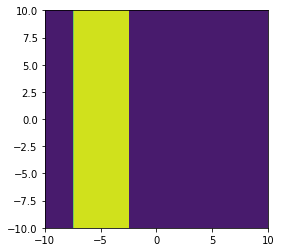

In [137]:
fig = plt.figure(figsize=(4, 4))
ax = plt.axes()  

# Animation function
def animate(i): 
    z = stim[i,:,:]
    cont = plt.contourf(X, Y, z)

    return cont  

anim = animation.FuncAnimation(fig, animate, frames=nFrames)

anim.save('stimulus.mp4', writer = 'ffmpeg', fps=1, codec='libx264')

with open('stimulus.mp4', 'rb') as f:
    video_tag = '<video controls alt="test" src="data:video/x-m4v;base64,{0}">'.format(base64.b64encode(f.read()).decode('utf-8'))

### Description and presentation
Drifting bar apertures at various orientations used in Dumoulin(2007) paper; The bar width subtended 1/4th of the stimulus radius. Four bar orientations and two different motion directions for each bar were used, giving a total of 8 different bar with 3 diffrent location which gives 24 configurations within a given scan as shown bellow.
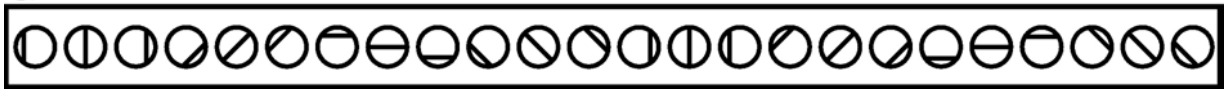

In [65]:
HTML(video_tag)

### Plot of overall visual field covered

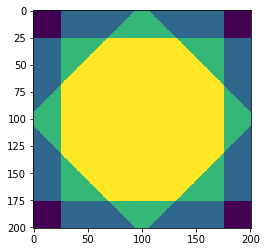

In [66]:
shape2D = (len(X), len(Y))
proj2D = np.zeros(shape2D)
for i in range(nFrames):
    proj2D = proj2D + (stim[i, :, :]).reshape(shape2D)
    
plt.imshow(proj2D)

## 1.2. Retinotopic Mapping
The retinotopic mapping can be moddeled using the log-polar transformation $dst( \rho , \phi ) = src(x, y)$ which emulates the human “foveal” vision where,

$$
\begin{array}{l}
\rho = M \cdot \ln{\sqrt{x^2 + y^2}}\\
\phi = \arctan{\frac{y}{x}}  \\
\end{array}
$$

M – Magnitude scale parameter. It determines the radius of the bounding circle to transform too.

### Demonstration
We can do a forward and backward transformation on a sample image to show the cortical zooming effect which is emulates the behaviour of fovea.

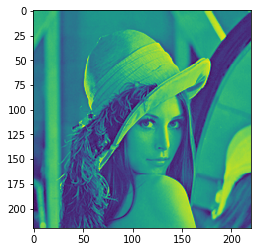

In [124]:
img_test = cv.imread('lenna.png', 0)
plt.imshow(img_test)

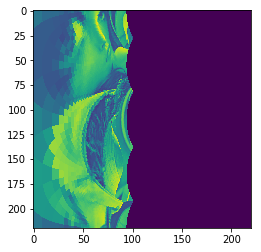

In [148]:
M = 20
center = (img_test.shape[0]/2, img_test.shape[1]/2)

warped_img = cv.logPolar(img_test, center, M, cv.WARP_FILL_OUTLIERS)
back_img = cv.logPolar(warped_img, center, M, cv.WARP_INVERSE_MAP + cv.WARP_FILL_OUTLIERS)

plt.imshow(warped_img)

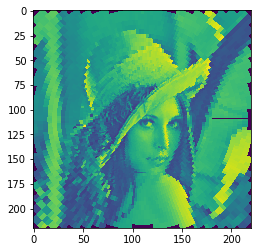

In [149]:
plt.imshow(back_img)

### Stimulus Mapping

In [127]:
M = 40
center = (stim.shape[1]/2, stim.shape[2]/2)
logpolar_stim = np.zeros(stim.shape)
recovered_stim = np.zeros(stim.shape)

for frame in range(nFrames):
    img = stim[frame, :, :]
    logpolar_stim[frame, :, :] = cv.logPolar(img, center, M, cv.WARP_FILL_OUTLIERS)
    recovered_stim[frame, :, :] = cv.logPolar(logpolar_stim[frame, :, :], center, M, cv.WARP_INVERSE_MAP + cv.WARP_FILL_OUTLIERS)

### Plot of overall visual cortex covered

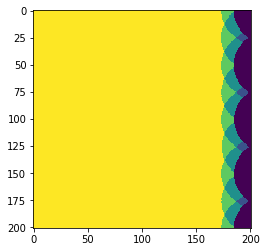

In [128]:
shape2D = (stim.shape[1], stim.shape[1])
proj2D = np.zeros(shape2D)
for frame in range(nFrames):
    proj2D = proj2D + (logpolar_stim[frame, :, :]).reshape(shape2D)
    
plt.imshow(proj2D)

### Animating

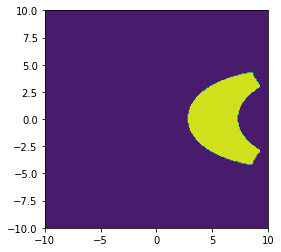

In [129]:
fig = plt.figure(figsize=(4, 4))
ax = plt.axes()  

# Animation function
def animate(i): 
    z = logpolar_stim[i,:,:]
    cont = plt.contourf(X, Y, z)
    return cont  

anim = animation.FuncAnimation(fig, animate, frames=nFrames)

anim.save('mappedStimulus.mp4', fps=1, codec='libx264')

with open('mappedStimulus.mp4', 'rb') as f:
    video_tag = '<video controls alt="test" src="data:video/x-m4v;base64,{0}">'.format(base64.b64encode(f.read()).decode('utf-8'))

### Comparing the stimulus with its cortical mapping
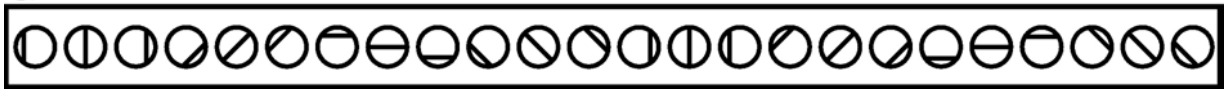

In [130]:
HTML(video_tag)

## 1.3. Downsampling the cortical map
Here we downasmple log-polar trasformed stimulus which approximately gives the map of activated areas in visual cortex. Each of thess samples correspond to a boxcar (since its zero or one) neuoronal response of an fMRI voxel in the visual cortex.

Let's say on average, the surface area of V1 is about 3000 $mm^3$ and the fMRI voxel sizes are 3x3x3 mm. Therefore there should be about a 1000 voxels in the fMRI data that corresponds to t30he V1 area. So let's downsample the cortical map into 30X30.

In [150]:
nVoxels = 30
neuronal_responses = np.zeros((nFrames, nVoxels, nVoxels))
for frame in range(nFrames):
    img = logpolar_stim[frame, :, :]
    img_resized = resize(img, (nVoxels, nVoxels), mode='constant', preserve_range=True)
    img_resized = (img_resized >= 0.5)*1
    neuronal_responses[frame, :, :] = img_resized

### Plot of overall voxels activated

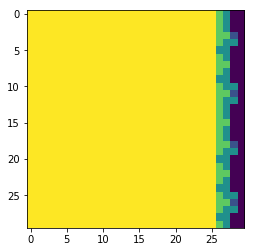

In [151]:
shape2D = (neuronal_responses.shape[1], neuronal_responses.shape[1])
proj2D = np.zeros(shape2D)
for frame in range(nFrames):
    proj2D = proj2D + (neuronal_responses[frame, :, :]).reshape(shape2D)
    
plt.imshow(proj2D)

### Animating

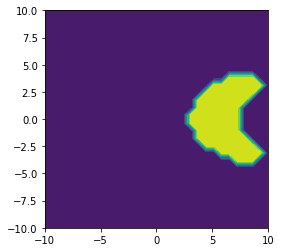

In [133]:
fig = plt.figure(figsize=(4, 4))
ax = plt.axes()  

size = np.linspace(-radius, radius, nVoxels)
# Animation function
def animate(i): 
    z = neuronal_response[i,:,:]
    cont = plt.contourf(size, size, z)
    return cont  

anim = animation.FuncAnimation(fig, animate, frames=nFrames)

anim.save('neuronalResponses.mp4', fps=1, codec='libx264')

with open('neuronalResponses.mp4', 'rb') as f:
    video_tag = '<video controls alt="test" src="data:video/x-m4v;base64,{0}">'.format(base64.b64encode(f.read()).decode('utf-8'))

In [134]:
HTML(video_tag)

## 1.4. Experiment Parmeters
Now we need to assume the experiment parameters such as the TR and the event duration times.

In [272]:
TR = 3.0
TRs = 5 # number of TRs for each frame

responses = np.zeros((nFrames*duration, nVoxels, nVoxels))
t = np.arange(0,nFrames*duration*TR,TR)

# extending the stimlus time to allow TRs for each event
for frame in range(nFrames):
    for i in range(TRs):
        responses[frame*TRs + i, :, :] = neuronal_response[frame, :, :]

## 1.5. Modelling BOLD Response
We can model the Hemodynamic response by assuming an LTI system and use the signle or double Gamma function as the impulse response. 
We can define the gamma distribution by providing its PDF: 
$$
f_X(x) = \frac{\lambda^{\alpha} x^{\alpha-1} e^{-\lambda x}}{\Gamma(\alpha)} \hspace {5pt} x > 0\\
\Gamma(\alpha) = \int_0^\infty x^{\alpha - 1} e^{-x} {\rm d}x, \hspace{20pt} \textrm{for }\alpha>0.
$$

Specifically, if $n \in \{1,2,3,...\}$, then
$$
\Gamma(n) = (n-1)!
$$


Therefore we can use a single shifted Gamma distribution with shape parameter n and rate $\lambda$ as the impulse reponse for the hemodynamic system,
$$
h(t) = \frac{\lambda^{n} (t-t_0)^{n-1} e^{-\lambda (t-t_0)}}{(n-1)!}
$$


In [273]:
def hrf_single_gamma(t,n,lmbd,t0):
    return gamma.pdf(t,n,loc=t0,scale=lmbd)


def hrf_double_gamma(t,n1,n2,lmbd1,lmbd2,t01,t02,a):
    c = (gamma.cdf(t[t.size-1],n1,loc=t01,scale=lmbd1) 
        - a * gamma.cdf(t[t.size-1],n2,loc=t02,scale=lmbd2))
            
    return ( 1/c * (gamma.pdf(t,n1,scale=lmbd1,loc=t01) 
                   - a * gamma.pdf(t,n2,scale=lmbd2,loc=t02)) )

### Choosing the HRF

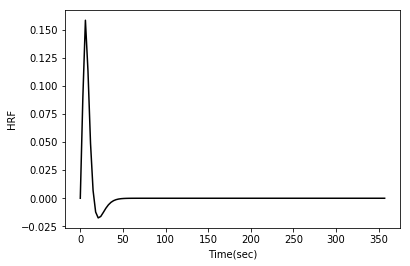

In [274]:
# parameters for double gamma distribution function hrf:
n1 = 4
lmbd1 = 2.0
t01 = 0
n2 = 7
lmbd2 = 3
t02 = 0
a = 0.3


hrf = hrf_double_gamma(t, n1, n2, lmbd1, lmbd2, t01, t02, a)


plt.plot(t, hrf, color = 'black')
plt.xlabel('Time(sec)')
plt.ylabel('HRF')
plt.show()

### Choosing a sample

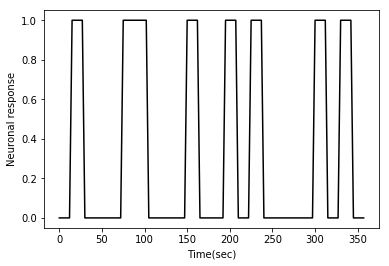

In [275]:
n = responses[:, 10, 20]

plt.plot(t, n, color = 'black')
plt.xlabel('Time(sec)')
plt.ylabel('Neuronal response')
plt.show()

In [276]:
bold = np.convolve(hrf, n)

In [277]:
bold = bold[0:len(t)]
bold_noisy = bold + norm.rvs(scale=0.1, size=bold.size)

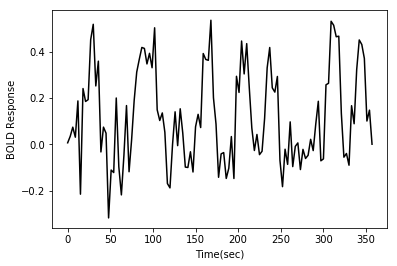

In [278]:
plt.plot(t, bold_noisy, color = 'black')
plt.xlabel('Time(sec)')
plt.ylabel('BOLD Response')
plt.show()

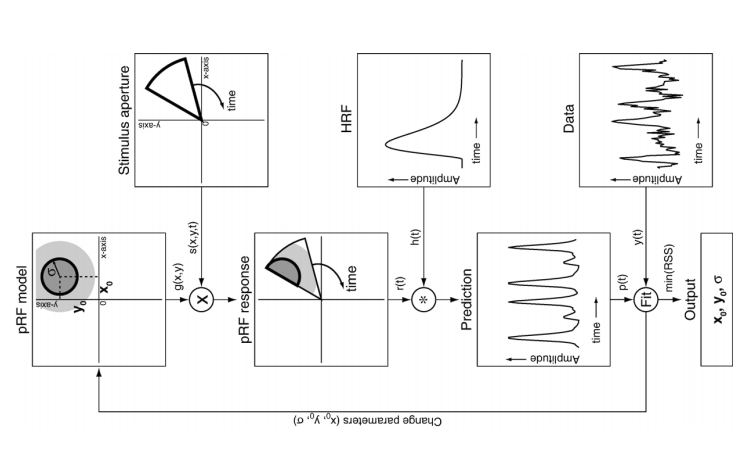